In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [ ]:
#데이터 불러오기(경로)
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')

In [ ]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 코인별 인덱스 뽑기
def coin_index_export(input_array, coin_num):

    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            #print(sample_id)
            index.append(sample_id)
    return index


# n분봉으로 나누는 함수
# idxsize= _array[0], time_size = _array[1], time_split = 몇분봉으로 나눌건지, arrayy = array명
def time_split(input_array, split_size = 6):

    # origin size define
    index_size = input_array.shape[0]
    origin_time_size = input_array.shape[1]
    variable_size = input_array.shape[2]

    # new array size define
    new_time_size = int(origin_time_size/split_size) # 1380 / 6
    new_array = np.zeros((index_size, new_time_size, variable_size))

    for idx in range(index_size):
        for time_idx in range(new_time_size):
            

            first_time_idx = time_idx * split_size
            last_time_idx = ((time_idx+1) * split_size) -1

            new_array[idx, time_idx, 0] = input_array[idx, first_time_idx, 0] #coin_num
            new_array[idx, time_idx, 1] = input_array[idx, first_time_idx, 1] #open
            
            new_array[idx, time_idx, 2] = np.max(input_array[idx, first_time_idx:last_time_idx, 2]) #high
            new_array[idx, time_idx, 3] = np.min(input_array[idx, first_time_idx:last_time_idx, 3]) #low

            new_array[idx, time_idx, 4] = input_array[idx, last_time_idx, 4] #close

            new_array[idx, time_idx, 5] = np.sum(input_array[idx, first_time_idx:last_time_idx, 5]) #etc
            new_array[idx, time_idx, 6] = np.sum(input_array[idx, first_time_idx:last_time_idx, 6]) #etc
            new_array[idx, time_idx, 7] = np.sum(input_array[idx, first_time_idx:last_time_idx, 7]) #etc
            new_array[idx, time_idx, 8] = np.sum(input_array[idx, first_time_idx:last_time_idx, 8]) #etc
            new_array[idx, time_idx, 9] = np.sum(input_array[idx, first_time_idx:last_time_idx, 9]) #etc

    return new_array

def moving_average(arr, window_size=10):
    # length = ma 몇 할지
    length = window_size

    ma = np.zeros((arr.shape[0], arr.shape[1] - length, arr.shape[2]))

    for idx in range(arr.shape[0]):
        for i in range(length, arr.shape[1]):
            for col in range(arr.shape[2]):
                ma[idx, i - length, col] = arr[idx, i - length:i, col].mean()  # open

    return ma

In [ ]:
data = pd.read_hdf('/content/drive/MyDrive/colab_data/merged_data.h5')

In [ ]:
df = df2d_to_array3d(data)

In [ ]:
split_df = time_split(df, split_size=6)

In [ ]:
split_df = moving_average(split_df)

In [ ]:
split_df.shape

(1208, 240, 10)

In [ ]:
X_train = split_df[:,:220,1:]
y_train = split_df[:,220:,1]

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1208, 220, 9)
(1208, 20)


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                               strides=1, padding="causal",
                               activation="relu",
                               input_shape=[None, 9]),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,                      return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=False)),
        tf.keras.layers.Dense(20)])

In [ ]:
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
history = model.fit(X_train, y_train, epochs=50,batch_size = 4, validation_split=0.2)

Epoch 1/50
242/242 [==============================] - 56s 206ms/step - loss: 0.0953 - mean_absolute_error: 0.1521 - val_loss: 1.3625e-04 - val_mean_absolute_error: 0.0080
Epoch 2/50
242/242 [==============================] - 48s 199ms/step - loss: 1.0757e-04 - mean_absolute_error: 0.0073 - val_loss: 1.0089e-04 - val_mean_absolute_error: 0.0069
Epoch 3/50
242/242 [==============================] - 49s 201ms/step - loss: 7.5612e-05 - mean_absolute_error: 0.0062 - val_loss: 9.1628e-05 - val_mean_absolute_error: 0.0065
Epoch 4/50
242/242 [==============================] - 49s 201ms/step - loss: 6.4500e-05 - mean_absolute_error: 0.0057 - val_loss: 8.6806e-05 - val_mean_absolute_error: 0.0063
Epoch 5/50
242/242 [==============================] - 49s 202ms/step - loss: 6.5333e-05 - mean_absolute_error: 0.0056 - val_loss: 9.3034e-05 - val_mean_absolute_error: 0.0067
Epoch 6/50
242/242 [==============================] - 50s 206ms/step - loss: 5.1460e-05 - mean_absolute_error: 0.0050 - val_loss:

In [ ]:
idx = 2

x1 = X_train[idx,:,:].reshape(1,220,9)
y1 = model.predict(x1)

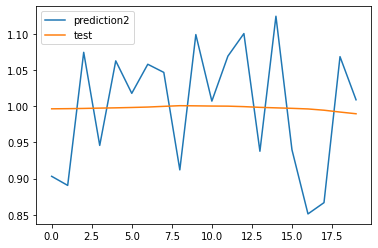

In [ ]:
#plt.plot(y1.reshape(-1),label="prediction")
plt.plot(y1.reshape(-1),label="prediction2")
plt.plot(y_train[idx,:],label = "test")
#plt.plot(x_values1,df2[idx,-90:,1],label="test function")
plt.legend()
plt.show()